## Preamble

In [31]:
%matplotlib inline

from sympy import Symbol, symbols, pprint, Interval
from sympy import sin, cos, sqrt, pi, oo, Pow, discriminant
from sympy import diff, solve, nsolve, apart, expand, factor, lambdify, simplify, Eq, re, im
from sympy import init_printing

from sympy.integrals import integrate
from sympy.physics.vector import ReferenceFrame, divergence, gradient, scalar_potential
from sympy.abc import epsilon, beta

import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import fsolve

In [2]:
### Declare coefficients and scalar variables as SymPy symbols

n0, nc, ns, nt = symbols('n0 nc ns nt') # density
A = symbols('A') # amplitude
q = symbols('q', positive=True) # reciprocal lattice spacing
R = ReferenceFrame('R') # coordinates: x=R[0], y=R[1]
init_printing()

## Setup density fields
nstr = n0 + A * cos(q*R[0])
ntri = n0 + A * (cos(q*R[1]/2)*cos(sqrt(3)*q*R[0]/2) - cos(q*R[1])/2)

In [3]:
pprint(nstr)

A⋅cos(Rₓ⋅q) + n₀


In [4]:
pprint(ntri)

  ⎛   ⎛R_y⋅q⎞    ⎛√3⋅Rₓ⋅q⎞   cos(R_y⋅q)⎞     
A⋅⎜cos⎜─────⎟⋅cos⎜───────⎟ - ──────────⎟ + n₀
  ⎝   ⎝  2  ⎠    ⎝   2   ⎠       2     ⎠     


In [5]:
### Plot densities

## Prepare plotting arrays
N = 100

xs = np.zeros(N*N)
ys = np.zeros(N*N)
zs = np.zeros(N*N)
zt = np.zeros(N*N)

for j in range(N):
    for i in range(N):
        x = -10 + 20./N * i
        y = -10 + 20./N * j
        xs[N*j+i] = x
        ys[N*j+i] = y
        zs[N*j+i] = nstr.subs({n0:0, A:-0.2, q:1, R[0]:x, R[1]:y})
        zt[N*j+i] = ntri.subs({n0:0, A:-0.2, q:1, R[0]:x, R[1]:y})

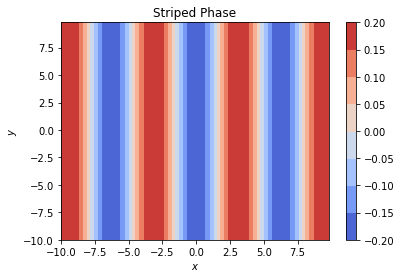

In [6]:
plt.figure()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Striped Phase")
Cs = plt.tricontourf(xs, ys, zs, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar(Cs)

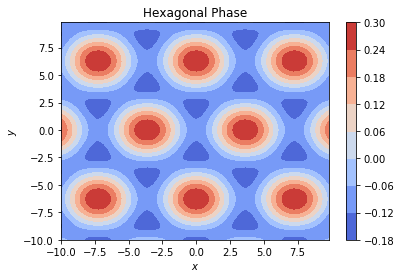

In [7]:
plt.figure()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Hexagonal Phase")
Ct = plt.tricontourf(xs, ys, zt, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar(Ct)

## Define free energy density

In [8]:
### Define density gradients

grad2str = divergence(gradient(nstr, R), R)
grad4str = divergence(gradient(divergence(gradient(nstr, R), R), R), R)

quadstr = nstr/2 * (epsilon*nstr + (nstr + 2*grad2str + grad4str))
cubestr = -beta/3 * nstr**3
quarstr = nstr**4 / 4

grad2tri = divergence(gradient(ntri, R), R)
grad4tri = divergence(gradient(divergence(gradient(ntri, R), R), R), R)

quadtri = ntri/2 * (epsilon*ntri + (ntri + 2*grad2tri + grad4tri))
cubetri = -beta/3 * ntri**3
quartri = ntri**4 / 4

In [9]:
### Integrate energy over striped unit wavelength

astr = 2*pi/q
F_str = simplify(1/astr * expand(integrate(quadstr + cubestr + quarstr, (R[0], 0, astr))))
pprint(F_str)

   4    2         2        2   2    2  2 ⎛ 2    ⎞    2       3       2     4  
3⋅A    A ⋅β⋅n₀   A ⋅ε   3⋅A ⋅n₀    A ⋅q ⋅⎝q  - 2⎠   A    β⋅n₀    ε⋅n₀    n₀   
──── - ─────── + ──── + ──────── + ────────────── + ── - ───── + ───── + ─── +
 32       2       4        4             4          4      3       2      4   

   2
 n₀ 
 ───
  2 


In [10]:
### Integrate energy over triangle unit cell

atri = 2*pi/q
F_tri = simplify(1/(2*atri*2/sqrt(3)*atri) * expand(integrate(quadtri + cubetri + quartri, (R[0], 0, 2*atri/sqrt(3)), (R[1], 0, 2*atri))))
pprint(F_tri)

    4    3        3         2           2        2   2      2  4      2  2    
45⋅A    A ⋅β   3⋅A ⋅n₀   3⋅A ⋅β⋅n₀   3⋅A ⋅ε   9⋅A ⋅n₀    3⋅A ⋅q    3⋅A ⋅q    3
───── + ──── - ─────── - ───────── + ────── + ──────── + ─────── - ─────── + ─
 512     16       16         8         16        16         16        8       

  2       3       2     4     2
⋅A    β⋅n₀    ε⋅n₀    n₀    n₀ 
─── - ───── + ───── + ─── + ───
16      3       2      4     2 


## Optimize Parameters

In [11]:
### Solve for q

qstr = solve(Eq(diff(F_str, q), 0), q)
pprint(qstr)

[1]


In [12]:
qtri = solve(Eq(diff(F_tri, q), 0), q)
pprint(qtri)

[1]


In [13]:
### Solve for A

Astr = solve(Eq(diff(F_str.subs({q:qstr[0]}), A), 0), A)
pprint(Astr)

⎡            ____________________           ____________________⎤
⎢           ╱                  2           ╱                  2 ⎥
⎢   -2⋅√3⋅╲╱  2⋅β⋅n₀ - ε - 3⋅n₀     2⋅√3⋅╲╱  2⋅β⋅n₀ - ε - 3⋅n₀  ⎥
⎢0, ──────────────────────────────, ────────────────────────────⎥
⎣                 3                              3              ⎦


In [14]:
Atri = solve(Eq(diff(F_tri.subs({q:qtri[0]}), A), 0), A)
pprint(Atri)

⎡                       ______________________________                      __
⎢                      ╱  2                         2                      ╱  
⎢     4⋅β   4⋅n₀   4⋅╲╱  β  + 24⋅β⋅n₀ - 15⋅ε - 36⋅n₀      4⋅β   4⋅n₀   4⋅╲╱  β
⎢0, - ─── + ──── - ───────────────────────────────────, - ─── + ──── + ───────
⎣      15    5                      15                     15    5            

____________________________⎤
2                         2 ⎥
  + 24⋅β⋅n₀ - 15⋅ε - 36⋅n₀  ⎥
────────────────────────────⎥
          15                ⎦


In [15]:
### Substitute optimal parameters into free energy expressions

F_con = F_tri.subs({q:1, A:0})
pprint(F_con)

      3       2     4     2
  β⋅n₀    ε⋅n₀    n₀    n₀ 
- ───── + ───── + ─── + ───
    3       2      4     2 


In [16]:
F_str = F_str.subs({q:qstr[0], A:Astr[2]})
pprint(F_str)

               ⎛8⋅β⋅n₀   4⋅ε       2⎞             ⎛8⋅β⋅n₀   4⋅ε       2⎞      
      3   β⋅n₀⋅⎜────── - ─── - 4⋅n₀ ⎟       2   ε⋅⎜────── - ─── - 4⋅n₀ ⎟     4
  β⋅n₀         ⎝  3       3         ⎠   ε⋅n₀      ⎝  3       3         ⎠   n₀ 
- ───── - ─────────────────────────── + ───── + ──────────────────────── + ───
    3                  2                  2                4                4 

       2 ⎛8⋅β⋅n₀   4⋅ε       2⎞                             2
   3⋅n₀ ⋅⎜────── - ─── - 4⋅n₀ ⎟     2   ⎛                 2⎞ 
         ⎝  3       3         ⎠   n₀    ⎝2⋅β⋅n₀ - ε - 3⋅n₀ ⎠ 
 + ──────────────────────────── + ─── + ─────────────────────
                4                  2              6          


In [17]:
F_tri = F_tri.subs({q:qtri[0], A:Atri[1]})
pprint(F_tri)

                                                                     2        
                 ⎛                    ______________________________⎞      ⎛  
                 ⎜                   ╱  2                         2 ⎟      ⎜  
                 ⎜  4⋅β   4⋅n₀   4⋅╲╱  β  + 24⋅β⋅n₀ - 15⋅ε - 36⋅n₀  ⎟      ⎜  
      3   3⋅β⋅n₀⋅⎜- ─── + ──── - ───────────────────────────────────⎟    β⋅⎜- 
  β⋅n₀           ⎝   15    5                      15                ⎠      ⎝  
- ───── - ──────────────────────────────────────────────────────────── + ─────
    3                                  8                                      

                                                 3                            
                  ______________________________⎞                ⎛            
                 ╱  2                         2 ⎟                ⎜            
4⋅β   4⋅n₀   4⋅╲╱  β  + 24⋅β⋅n₀ - 15⋅ε - 36⋅n₀  ⎟                ⎜  4⋅β   4⋅n₀
─── + ──── - ───────────────────────────────────⎟  

## Plot free energy curves

In [18]:
bet = 0.5
eps = 0.05
xs = np.linspace(-0.5, 0.5, 100)
Fc = np.zeros(100)
Fs = np.zeros(100)
Ft = np.zeros(100)
for i in range(len(xs)):
    Fc[i] = re(F_con.subs({beta:bet, epsilon:eps, n0:xs[i]}))
    Fs[i] = re(F_str.subs({beta:bet, epsilon:eps, n0:xs[i]}))
    Ft[i] = re(F_tri.subs({beta:bet, epsilon:eps, n0:xs[i]}))

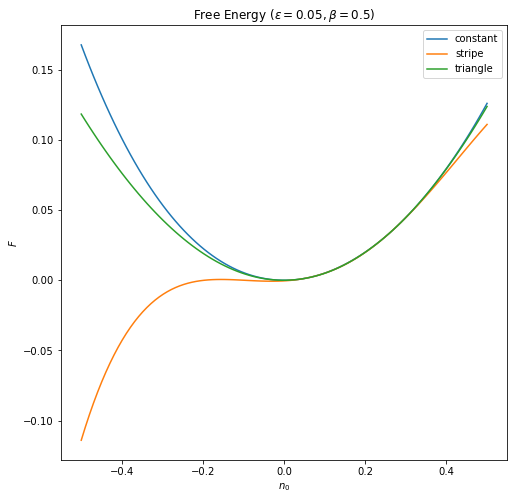

In [19]:
plt.figure(figsize=(8,8))
plt.xlabel("$n_0$")
plt.ylabel("$F$")
plt.title(r"Free Energy $(\epsilon=0.05,\beta=0.5)$")
plt.plot(xs, Fc, label="constant")
plt.plot(xs, Fs, label="stripe")
plt.plot(xs, Ft, label="triangle")
plt.legend(loc="best")

# Construct the Phase Diagram with $\beta=0$

In [20]:
### Define thermodynamic potentials (three phases)

fcon = F_con.subs({beta:0, n0:nc})
dfcon = diff(fcon, nc)

fstr = F_str.subs({beta:0, n0:ns})
dfstr = diff(fstr, ns)

ftri = F_tri.subs({beta:0, n0:nt})
dftri = diff(ftri, nt)

In [21]:
### Define equations to solve (constant and triangular phases)

eqn1 = dfcon - dftri
eqn2 = fcon - ftri - dfcon * (nc - nt)

def conTriSolver(eps, gc, gt):
    def eqncouple(N):
        return [f1(N[0],N[1]),
                f2(N[0],N[1])]
    
    def eqnjacob(N):
        return [[j1c(N[0],N[1]), j1t(N[0],N[1])],
                [j2c(N[0],N[1]), j2t(N[0],N[1])]]
    
    ### Generate numerically efficient expressions
    variables = (nc, nt)
    f1  = lambdify(variables, re(eqn1.subs({epsilon:eps})), modules='sympy')
    f2  = lambdify(variables, re(eqn2.subs({epsilon:eps})), modules='sympy')

    ### Generate Jacobian matrix expressions
    j1c = lambdify(variables, re(diff(eqn1.subs({epsilon:eps}), nc)), modules='sympy')
    j1t = lambdify(variables, re(diff(eqn1.subs({epsilon:eps}), nt)), modules='sympy')

    j2c = lambdify(variables, re(diff(eqn2.subs({epsilon:eps}), nc)), modules='sympy')
    j2t = lambdify(variables, re(diff(eqn2.subs({epsilon:eps}), nt)), modules='sympy')  

    ### Find the roots (fsolve assumes the expressions equal zero)
    guess = [gc, gt]

    return fsolve(func=eqncouple, x0=guess, fprime=eqnjacob)

### Evaluate a test point to confirm the solver works
solcontri = conTriSolver(-0.26, -0.35, -0.30)
print(solcontri)

[-0.34642971 -0.29525346]


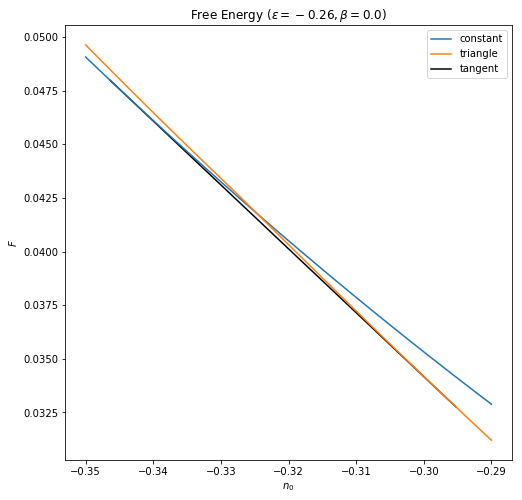

In [22]:
### Plot the tangent to confirm this result (sanity check)

xs = np.linspace(-0.35, -0.29, 100)
Fc = np.zeros(100)
Fs = np.zeros(100)
Ft = np.zeros(100)
for i in range(len(xs)):
    Fc[i] = re(F_con.subs({beta:0, epsilon:-0.26, n0:xs[i]}))
    Ft[i] = re(F_tri.subs({beta:0, epsilon:-0.26, n0:xs[i]}))

tangent = (re(F_con.subs({beta:0, epsilon:-0.26, n0:solcontri[0]})),
           re(F_tri.subs({beta:0, epsilon:-0.26, n0:solcontri[1]})))

plt.figure(figsize=(8,8))
plt.xlabel("$n_0$")
plt.ylabel("$F$")
plt.title(r"Free Energy $(\epsilon=-0.26,\beta=0.0)$")
plt.plot(xs, Fc, label="constant", zorder=10)
plt.plot(xs, Ft, label="triangle", zorder=10)
plt.plot(solcontri, tangent, label="tangent", color="black", zorder=1)
plt.legend(loc="best")

In [23]:
### Define equations to solve (stripe and triangular phases)

eqn3 = dfstr - dftri
eqn4 = fstr - ftri - dfstr * (ns - nt)

def strTriSolver(eps, gs, gt):
    def eqncouple(N):
        return [f3(N[0],N[1]),
                f4(N[0],N[1])]
    
    def eqnjacob(N):
        return [[j3s(N[0],N[1]), j3t(N[0],N[1])],
                [j4s(N[0],N[1]), j4t(N[0],N[1])]]

    ### Generate numerically efficient expressions
    variables = (ns, nt)
    f3  = lambdify(variables, re(eqn3.subs({epsilon:eps})), modules='sympy')
    f4  = lambdify(variables, re(eqn4.subs({epsilon:eps})), modules='sympy')

    ### Generate Jacobian matrix expressions
    j3s = lambdify(variables, re(diff(eqn3.subs({epsilon:eps}), ns)), modules='sympy')
    j3t = lambdify(variables, re(diff(eqn3.subs({epsilon:eps}), nt)), modules='sympy')

    j4s = lambdify(variables, re(diff(eqn4.subs({epsilon:eps}), ns)), modules='sympy')
    j4t = lambdify(variables, re(diff(eqn4.subs({epsilon:eps}), nt)), modules='sympy')

    ### Find the roots (fsolve assumes the expressions equal zero)
    guess = [gs, gt]

    return fsolve(func=eqncouple, x0=guess, fprime=eqnjacob)

In [24]:
### Notice that the triangle phase falls in-between the constant and striped phases.
### Therefore, solve for con-tri tangent and tri-str tangent, and plot the endpoints
### to form the complete three-phase phase diagram.

npts = 50

epsspace  = np.linspace(-0.300, 0.0, npts, endpoint=False)

conTriSpaceC = 2.69747*epsspace**2 + 1.88591*epsspace - .0393605
conTriSpaceT = 3.05796*epsspace**2 + 1.77292*epsspace - .0423643

strTriSpaceS = .831298*epsspace**2 + .655183*epsspace - .0134686
strTriSpaceT = 1.19821*epsspace**2 + .588424*epsspace - .0138189

conTriResult = np.zeros((npts,2))
strTriResult = np.zeros((npts,2))

for i in range(len(epsspace)):
    conTriResult[i] = conTriSolver(epsspace[i], conTriSpaceC[i], conTriSpaceT[i])
    strTriResult[i] = strTriSolver(epsspace[i], strTriSpaceS[i], strTriSpaceT[i])

conTriPoints = conTriResult.T
strTriPoints = strTriResult.T

<string>:1: RuntimeWarning: invalid value encountered in double_scalars
/users/tnk10/.conda/envs/mmsp/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


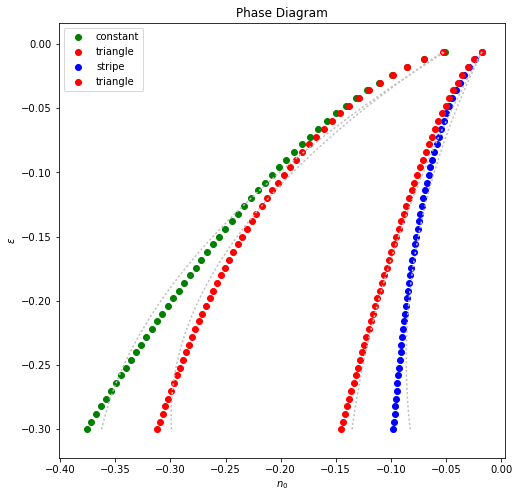

In [25]:
### Plot phase diagram

plt.figure(figsize=(8,8))
plt.xlabel("$n_0$")
plt.ylabel("$\epsilon$")
plt.title(r"Phase Diagram")
plt.scatter(conTriPoints[0], epsspace, c='green', label="constant")
plt.scatter(conTriPoints[1], epsspace, c='red', label="triangle")
plt.scatter(strTriPoints[0], epsspace, c='blue', label="stripe")
plt.scatter(strTriPoints[1], epsspace, c='red', label="triangle")
plt.plot(conTriSpaceC, epsspace, c='silver', ls=':')
plt.plot(conTriSpaceT, epsspace, c='silver', ls=':')
plt.plot(strTriSpaceS, epsspace, c='silver', ls=':')
plt.plot(strTriSpaceT, epsspace, c='silver', ls=':')
plt.legend(loc="best")

# Construct the Phase Diagram with $\beta=\frac{1}{2}$

In [26]:
### Define thermodynamic potentials (three phases)

fcon2 = F_con.subs({beta:0.5, n0:nc})
dfcon2 = diff(fcon2, nc)

fstr2 = F_str.subs({beta:0.5, n0:ns})
dfstr2 = diff(fstr2, ns)

ftri2 = F_tri.subs({beta:0.5, n0:nt})
dftri2 = diff(ftri2, nt)

In [27]:
### Define equations to solve (constant and triangular phases)

eqn5 = dfcon2 - dftri2
eqn6 = fcon2 - ftri2 - dfcon2 * (nc - nt)

def conTriSolver2(eps, gc, gt):
    def eqncouple(N):
        return [f5(N[0],N[1]),
                f6(N[0],N[1])]
    
    def eqnjacob(N):
        return [[j5c(N[0],N[1]), j5t(N[0],N[1])],
                [j6c(N[0],N[1]), j6t(N[0],N[1])]]

    ### Generate numerically efficient expressions
    variables = (nc, nt)
    f5  = lambdify(variables, re(eqn5.subs({epsilon:eps})), modules='sympy')
    f6  = lambdify(variables, re(eqn6.subs({epsilon:eps})), modules='sympy')

    ### Generate Jacobian matrix expressions
    j5c = lambdify(variables, re(diff(eqn5.subs({epsilon:eps}), nc)), modules='sympy')
    j5t = lambdify(variables, re(diff(eqn5.subs({epsilon:eps}), nt)), modules='sympy')

    j6c = lambdify(variables, re(diff(eqn6.subs({epsilon:eps}), nc)), modules='sympy')
    j6t = lambdify(variables, re(diff(eqn6.subs({epsilon:eps}), nt)), modules='sympy') 

    ### Find the roots (fsolve assumes the expressions equal zero)
    guess = [gc, gt]

    return fsolve(func=eqncouple, x0=guess, fprime=eqnjacob)

In [28]:
### Define equations to solve (stripe and triangular phases)

eqn7 = dfstr2 - dftri2
eqn8 = fstr2 - ftri2 - dfstr2 * (ns - nt)

def strTriSolver2(eps, gs, gt):
    def eqncouple(N):
        return [f7(N[0],N[1]),
                f8(N[0],N[1])]
    
    def eqnjacob(N):
        return [[j7s(N[0],N[1]), j7t(N[0],N[1])],
                [j8s(N[0],N[1]), j8t(N[0],N[1])]]

    ### Generate numerically efficient expressions
    variables = (ns, nt)
    f7  = lambdify(variables, re(eqn7.subs({epsilon:eps})), modules='sympy')
    f8  = lambdify(variables, re(eqn8.subs({epsilon:eps})), modules='sympy')

    ### Generate Jacobian matrix expressions
    j7s = lambdify(variables, re(diff(eqn7.subs({epsilon:eps}), ns)), modules='sympy')
    j7t = lambdify(variables, re(diff(eqn7.subs({epsilon:eps}), nt)), modules='sympy')

    j8s = lambdify(variables, re(diff(eqn8.subs({epsilon:eps}), ns)), modules='sympy')
    j8t = lambdify(variables, re(diff(eqn8.subs({epsilon:eps}), nt)), modules='sympy') 

    ### Find the roots (fsolve assumes the expressions equal zero)
    guess = [gs, gt]

    return fsolve(func=eqncouple, x0=guess, fprime=eqnjacob)

In [29]:
### Notice that the triangle phase falls in-between the constant and striped phases.
### Therefore, solve for con-tri tangent and tri-str tangent, and plot the endpoints
### to form the complete three-phase phase diagram.

npts = 100

epsspace2  = np.linspace(-0.300, 0.300, npts, endpoint=False)

conTriSpaceC2 = 0.610723*epsspace2**2 + 0.733473*epsspace2 - 0.0743776
conTriSpaceT2 = 0.797203*epsspace2**2 + 0.405734*epsspace2 + 0.0050629

strTriSpaceS2 = 0.191142*epsspace2**2 + 0.306340*epsspace2 + 0.174881
strTriSpaceT2 = 0.287879*epsspace2**2 + 0.101061*epsspace2 + 0.229864

conTriResult2 = np.zeros((npts,2))
strTriResult2 = np.zeros((npts,2))

for i in range(len(epsspace2)):
    conTriResult2[i] = conTriSolver2(epsspace2[i], conTriSpaceC2[i], conTriSpaceT2[i])
    strTriResult2[i] = strTriSolver2(epsspace2[i], strTriSpaceS2[i], strTriSpaceT2[i])

conTriPoints2 = conTriResult2.T
strTriPoints2 = strTriResult2.T

<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_

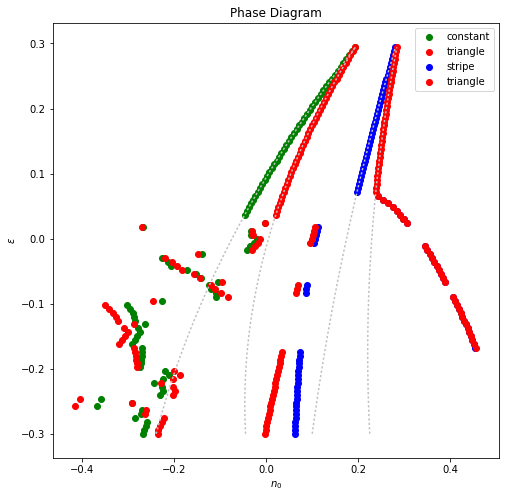

In [30]:
### Plot phase diagram

plt.figure(figsize=(8,8))
plt.xlabel("$n_0$")
plt.ylabel("$\epsilon$")
plt.title(r"Phase Diagram")
plt.scatter(conTriPoints2[0], epsspace2, c='green', label="constant")
plt.scatter(conTriPoints2[1], epsspace2, c='red', label="triangle")
plt.scatter(strTriPoints2[0], epsspace2, c='blue', label="stripe")
plt.scatter(strTriPoints2[1], epsspace2, c='red', label="triangle")
plt.plot(conTriSpaceC2, epsspace2, c='silver', ls=':')
plt.plot(conTriSpaceT2, epsspace2, c='silver', ls=':')
plt.plot(strTriSpaceS2, epsspace2, c='silver', ls=':')
plt.plot(strTriSpaceT2, epsspace2, c='silver', ls=':')
plt.legend(loc="best")